<a href="https://colab.research.google.com/github/RiyanMak/AIM25/blob/Landmark-detection/Merged_NueroCam_Pippelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries if not already installed
!pip install mediapipe opencv-python matplotlib numpy

# Import libraries
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files

# Initialize MediaPipe components
mp_face_mesh = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 17.4 MB/s eta 0:00:00


In [18]:
# Upload image
uploaded = files.upload()

# Get image path
image_path = list(uploaded.keys())[0]
print(f"Uploaded Image: {image_path}")

Saving czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvczkzLXBhLTU3OTgtam9iNTgzXzEuanBn.jpg.webp to czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvczkzLXBhLTU3OTgtam9iNTgzXzEuanBn.jpg.webp
Uploaded Image: czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvczkzLXBhLTU3OTgtam9iNTgzXzEuanBn.jpg.webp


In [12]:
class ImageProcessor:
    def __init__(self, image_size=(128, 128)):
        self.image_size = image_size

    def load_image(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            return None
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def process_landmarks(self, landmarks):
        return np.array(landmarks)  # Convert to NumPy array (you can normalize if needed)


def detect_faces(image, face_detection_model):
    """Detect faces in an image using MediaPipe Face Detection."""
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection_model.process(img_rgb)
    faces = []

    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            h, w, _ = image.shape
            bbox = (
                int(bboxC.xmin * w),
                int(bboxC.ymin * h),
                int(bboxC.width * w),
                int(bboxC.height * h),
            )
            faces.append(bbox)
    return faces


def extract_facial_landmarks(image, face_mesh_model):
    """Extract facial landmarks using MediaPipe Face Mesh."""
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh_model.process(img_rgb)
    landmarks_dict = {}

    if results.multi_face_landmarks:
        for face_idx, face_landmarks in enumerate(results.multi_face_landmarks):
            landmarks = [(lm.x, lm.y) for lm in face_landmarks.landmark]
            landmarks_dict[face_idx] = landmarks
    return landmarks_dict


def visualize_landmarks(image, landmarks_dict):
    """Draw facial landmarks on the image."""
    image_copy = image.copy()
    h, w, _ = image.shape

    for landmarks in landmarks_dict.values():
        for x, y in landmarks:
            cv2.circle(image_copy, (int(x * w), int(y * h)), 2, (0, 255, 0), -1)

    return image_copy


def extract_facial_features(landmarks):
    """Extract simple facial features (e.g., mean x and y coordinates)."""
    landmarks = np.array(landmarks)
    return {"mean_x": np.mean(landmarks[:, 0]), "mean_y": np.mean(landmarks[:, 1])}

In [6]:
def process_image_with_landmarks(image_path):
    processor = ImageProcessor(image_size=(128, 128))

    image = processor.load_image(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None, None, None

    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

    faces = detect_faces(image, face_detection)
    if not faces:
        print("No faces detected in the image.")
        return image, None, None

    landmarks_dict = extract_facial_landmarks(image, face_mesh)
    if not landmarks_dict:
        print("No facial landmarks detected.")
        return image, None, None

    processed_landmarks_dict = {}
    for face_idx, landmarks in landmarks_dict.items():
        processed_landmarks = processor.process_landmarks(landmarks)
        processed_landmarks_dict[face_idx] = processed_landmarks

    vis_image = visualize_landmarks(image, landmarks_dict)

    return image, vis_image, processed_landmarks_dict

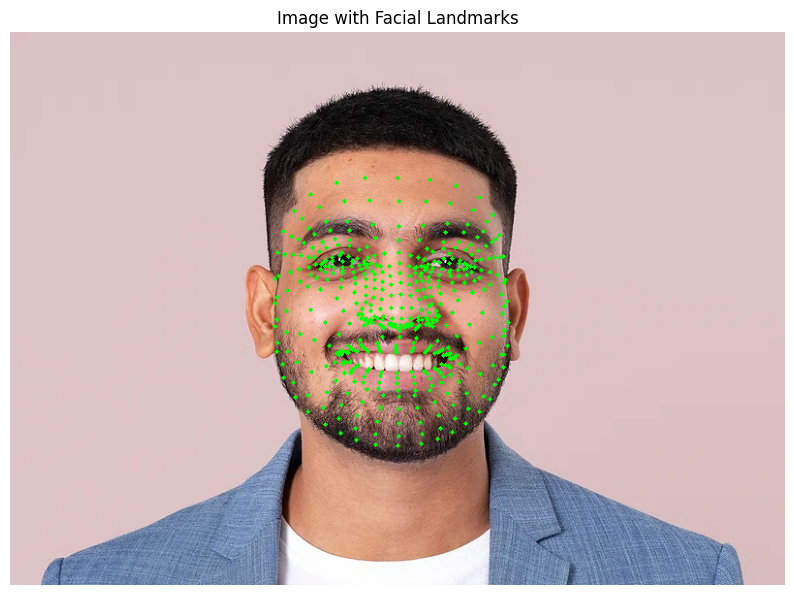

Face 0: 478 landmarks processed
Extracted Features:
  mean_x: 0.4993
  mean_y: 0.5055


In [19]:
# Run the processing function
original_image, vis_image, processed_landmarks = process_image_with_landmarks(image_path)

# Display the image with landmarks
if vis_image is not None:
    plt.figure(figsize=(10, 8))
    plt.imshow(vis_image)
    plt.title("Image with Facial Landmarks")
    plt.axis('off')
    plt.show()

    # Print extracted facial features
    if processed_landmarks:
        for face_idx, landmarks in processed_landmarks.items():
            print(f"Face {face_idx}: {len(landmarks)} landmarks processed")
            features = extract_facial_features(landmarks)
            print("Extracted Features:")
            for feature_name, value in features.items():
                print(f"  {feature_name}: {value:.4f}")

In [28]:
%%javascript
// Check if the video element already exists
if (!document.getElementById('myVideo')) {
  // Request webcam access only once
  navigator.mediaDevices.getUserMedia({video: true})
    .then(stream => {
      window.myVideoStream = stream;
      // Create a video element and attach the stream
      const video = document.createElement('video');
      video.id = 'myVideo';
      video.width = 640;
      video.height = 480;
      video.srcObject = stream;
      video.play();
      document.body.appendChild(video);
    })
    .catch(err => {
      console.error("Error accessing webcam: " + err);
    });
}

function captureFramePersistent() {
  const video = document.getElementById('myVideo');
  if (!video) {
    return null;
  }
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  return canvas.toDataURL('image/jpeg');
}


<IPython.core.display.Javascript object>

In [30]:
import cv2
import numpy as np
import base64
import time
from IPython.display import clear_output, display, Javascript
from google.colab.output import eval_js
import matplotlib.pyplot as plt

# Define a Python function to capture a frame from the persistent video stream
def capture_frame_persistent():
    data = eval_js('captureFramePersistent()')
    if data is None:
        return None
    header, encoded = data.split(',', 1)
    img_bytes = base64.b64decode(encoded)
    np_arr = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    return img

# Initialize your MediaPipe models for video mode (static_image_mode=False)
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection

face_mesh_video = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)
face_detection_video = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# Assuming your helper functions (detect_faces, extract_facial_landmarks, visualize_landmarks, ImageProcessor) are already defined

processor = ImageProcessor(image_size=(128, 128))

try:
    while True:
        frame = capture_frame_persistent()
        if frame is None:
            print("Error capturing frame")
            break

        # Convert captured frame from BGR to RGB if needed
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect faces
        faces = detect_faces(frame_rgb, face_detection_video)
        if faces:
            landmarks_dict = extract_facial_landmarks(frame_rgb, face_mesh_video)
            if landmarks_dict:
                processed_landmarks = {}
                for face_idx, landmarks in landmarks_dict.items():
                    processed_landmarks[face_idx] = processor.process_landmarks(landmarks)
                frame_processed = visualize_landmarks(frame, landmarks_dict)
            else:
                frame_processed = frame
        else:
            frame_processed = frame

        # Clear previous output and display the new frame
        clear_output(wait=True)
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(frame_processed, cv2.COLOR_BGR2RGB))
        plt.title("Live Webcam Feed with Facial Landmarks")
        plt.axis("off")
        plt.show()

        # Adjust delay (e.g., 0.1 seconds) for near real-time updates
        time.sleep(0.1)
except KeyboardInterrupt:
    print("Live video processing stopped.")
";.oiuytew"

MessageError: ReferenceError: Can't find variable: captureFramePersistent